In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

0. 首先为了排除数据中的NaN、无穷大这一类的数据，先处理缺失值or异常值

1. 由于将所有.h5文件并将其合并为一个DataFrame占内存空间太大了，于是采用分块处理数据，最后将结果聚合的方法

首先进行的是探索性数据分析（EDA）

In [2]:
def analyze_stock_data(df, stock_symbol):
    # 筛选出特定股票的数据
    stock_data = df[df['symbol'] == stock_symbol]
    
    # 打印数据概况
    print(f"Analyzing data for stock: {stock_symbol}")
    print(stock_data.info())
    print(stock_data.describe())
    
    # 绘制价格随时间变化的趋势图
    plt.figure(figsize=(10, 8))
    stock_data.plot(x='interval', y=['midpx', 'open', 'high', 'low', 'lastpx'])
    plt.title(f'Price Trends for {stock_symbol}')
    plt.xlabel('Time Interval')
    plt.ylabel('Price')
    plt.show()
    
    # 绘制交易量随时间变化的趋势图
    plt.figure(figsize=(10, 8))
    stock_data.plot(x='interval', y=['tradeBuyQty', 'tradeSellQty'])
    plt.title(f'Trading Volume Trends for {stock_symbol}')
    plt.xlabel('Time Interval')
    plt.ylabel('Volume')
    plt.show()
    
    # 绘制直方图，查看各特征分布
    stock_data.hist(bins=20, figsize=(15, 10))
    plt.suptitle(f'Histograms of Features for {stock_symbol}')
    plt.show()

    # 绘制箱线图，查看各特征的异常值
    plt.figure(figsize=(15, 10))
    stock_data.drop(columns=['symbol', 'interval']).boxplot(rot=90)
    plt.title(f'Boxplot of Features for {stock_symbol}')
    plt.show()

In [3]:
directory = "D:\\00-homework\\lectures\\00-machine_learning\\meow_github\\StockPricePrediction\\archive"

def process_single_file(file_path, stock_symbol):
    df = pd.read_hdf(file_path)
    print(f"Processing file: {file_path}")
    print(df.info())
    
    # 分析特定股票代码的数据
    analyze_stock_data(df, stock_symbol)

Processing file: D:\00-homework\lectures\00-machine_learning\meow_github\StockPricePrediction\archive\20230601.h5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69347 entries, 0 to 73838
Data columns (total 62 columns):
symbol               69347 non-null int64
interval             69347 non-null int64
fret12               69347 non-null float64
midpx                69347 non-null float64
lastpx               68899 non-null float64
open                 68899 non-null float64
high                 68899 non-null float64
low                  68899 non-null float64
bid0                 69347 non-null float64
ask0                 69347 non-null float64
bid4                 69347 non-null float64
ask4                 69346 non-null float64
bid9                 69347 non-null float64
ask9                 69346 non-null float64
bid19                69208 non-null float64
ask19                69345 non-null float64
bsize0               69347 non-null float64
asize0               69347 non-nu

<Figure size 720x576 with 0 Axes>

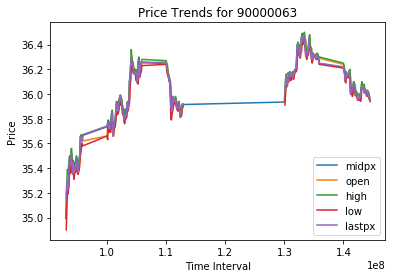

<Figure size 720x576 with 0 Axes>

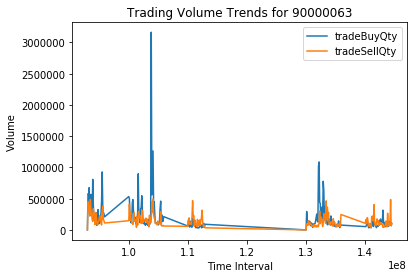

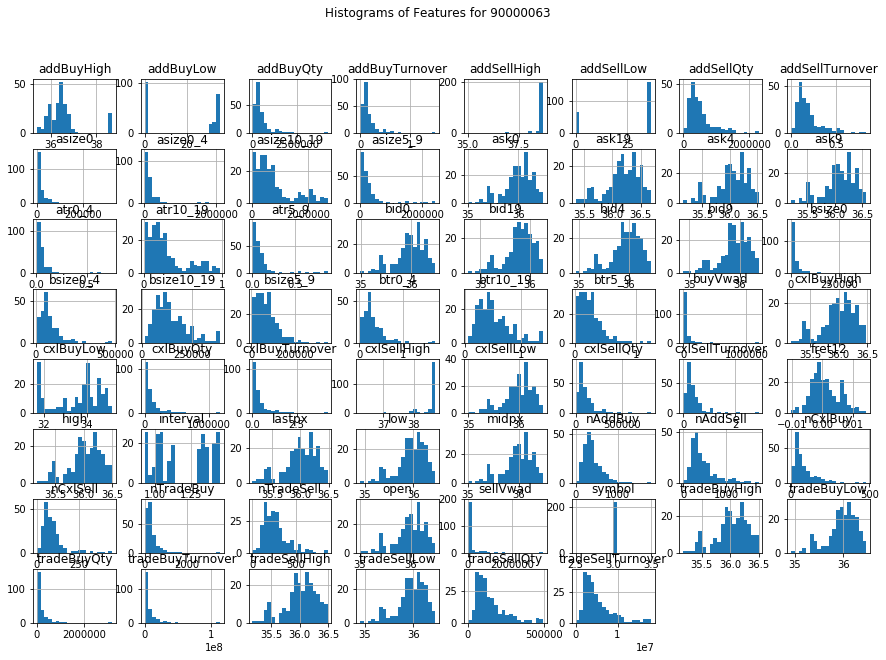

e:\anaconda_real\envs\gluon\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


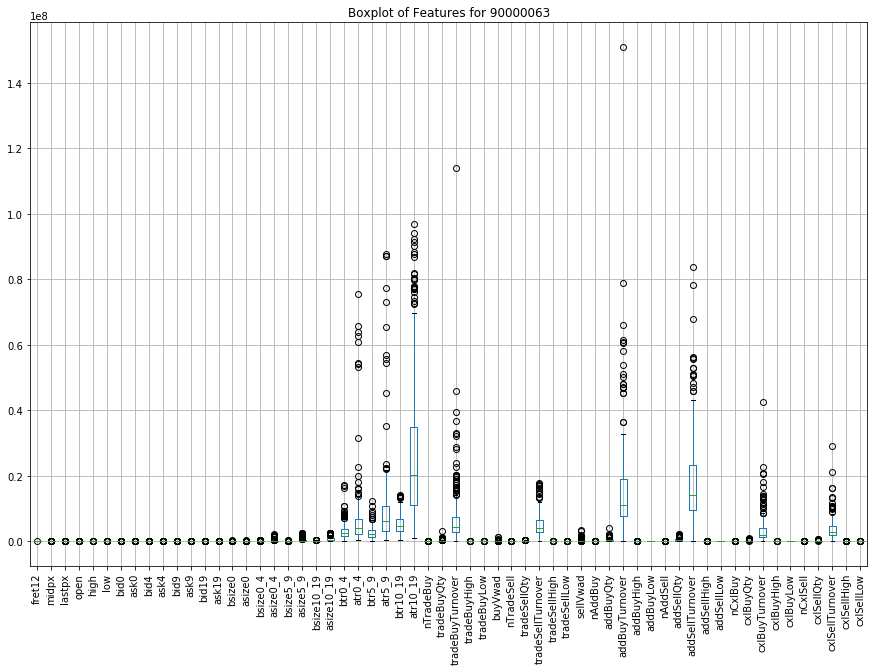

None


In [4]:
test_file_path = os.path.join(directory, "20230601.h5")
stock_symbol = 90000063
stats = process_single_file(test_file_path, stock_symbol)

# 打印描述统计量
print(stats)

其次是主成分分析（PCA）

In [40]:
def analyze_stock_data(df, stock_symbol):
    # 筛选出特定股票的数据
    stock_data = df[df['symbol'] == stock_symbol]
    
    # 打印数据概况
    print(f"Analyzing data for stock: {stock_symbol}")
    print(stock_data.info())
    print(stock_data.describe())
    
    # 绘制价格随时间变化的趋势图
    plt.figure(figsize=(10, 8))
    stock_data.plot(x='interval', y=['midpx', 'open', 'high', 'low', 'lastpx'])
    plt.title(f'Price Trends for {stock_symbol}')
    plt.xlabel('Time Interval')
    plt.ylabel('Price')
    plt.show()
    
    # 绘制交易量随时间变化的趋势图
    plt.figure(figsize=(10, 8))
    stock_data.plot(x='interval', y=['tradeBuyQty', 'tradeSellQty'])
    plt.title(f'Trading Volume Trends for {stock_symbol}')
    plt.xlabel('Time Interval')
    plt.ylabel('Volume')
    plt.show()
    
    # 处理缺失值和无穷大值
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    stock_data = stock_data[~((stock_data['interval'] % 1000000 >= 113000) & (stock_data['interval'] % 1000000 <= 130000))]
    df.fillna(method='ffill', inplace=True)  # 前向填充
    df.fillna(method='bfill', inplace=True)  # 后向填充
    df.fillna(stock_data.mean(), inplace=True)  # 如果前向和后向填充都无效，将剩余的NaN进行均值填充
    stock_data.dropna(inplace=True)
    
    # 归一化
    scaler = MinMaxScaler()
    stock_data_scaled = scaler.fit_transform(stock_data.drop(columns=['symbol', 'interval']))
    stock_data_scaled = pd.DataFrame(stock_data_scaled, columns=stock_data.columns.drop(['symbol', 'interval']))
    
    # 再次检查数据中是否有 NaN 或无穷大值
    if stock_data_scaled.isnull().values.any():
        print("Scaled data contains NaN values.")
    if np.isinf(stock_data_scaled).values.any():
        print("Scaled data contains infinity values.")
    
    # PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(stock_data_scaled)
    pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
    
    # 绘制 PCA 结果
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA Result for {stock_symbol}')
    plt.show()

In [41]:
directory = "D:\\00-homework\\lectures\\00-machine_learning\\meow_github\\StockPricePrediction\\archive"

def process_single_file(file_path, stock_symbol):
    df = pd.read_hdf(file_path)
    print(f"Processing file: {file_path}")
    print(df.info())
    
    # 分析特定股票代码的数据
    analyze_stock_data(df, stock_symbol)

测试生成单个文件的PCA结果

Processing file: D:\00-homework\lectures\00-machine_learning\meow_github\StockPricePrediction\archive\20230601.h5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69347 entries, 0 to 73838
Data columns (total 62 columns):
symbol               69347 non-null int64
interval             69347 non-null int64
fret12               69347 non-null float64
midpx                69347 non-null float64
lastpx               68899 non-null float64
open                 68899 non-null float64
high                 68899 non-null float64
low                  68899 non-null float64
bid0                 69347 non-null float64
ask0                 69347 non-null float64
bid4                 69347 non-null float64
ask4                 69346 non-null float64
bid9                 69347 non-null float64
ask9                 69346 non-null float64
bid19                69208 non-null float64
ask19                69345 non-null float64
bsize0               69347 non-null float64
asize0               69347 non-nu

<Figure size 720x576 with 0 Axes>

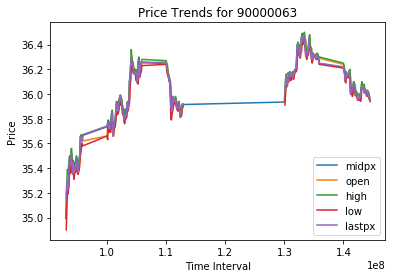

<Figure size 720x576 with 0 Axes>

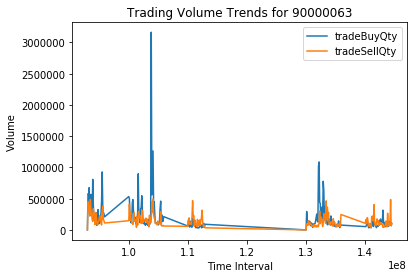

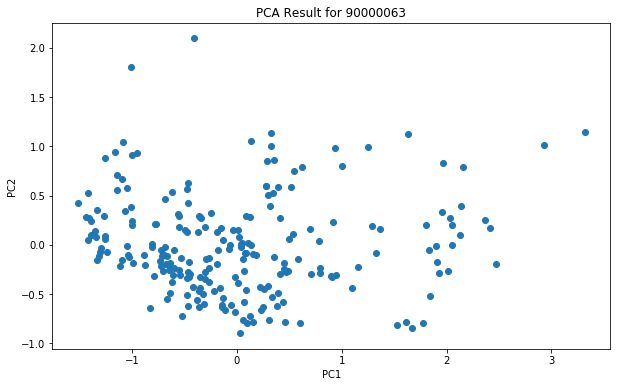

None


In [42]:
test_file_path = os.path.join(directory, "20230601.h5")
stock_symbol = 90000063
stats = process_single_file(test_file_path, stock_symbol)

# 打印描述统计量
print(stats)

3. 下面是对单个股票的长时间段数据进行PCA分析，并查看其时序特征，使用 load_and_concatenate_files 函数遍历指定目录中的所有 .h5 文件，加载数据并筛选出特定股票的数据，然后将所有数据合并

In [43]:
def load_and_concatenate_files(directory, stock_symbol):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".h5"):
            file_path = os.path.join(directory, filename)
            df = pd.read_hdf(file_path)
            # 筛选出特定股票的数据
            stock_data = df[df['symbol'] == stock_symbol]
            all_data.append(stock_data)
    
    # 合并所有数据
    concatenated_data = pd.concat(all_data, ignore_index=True)
    return concatenated_data


In [57]:
def plot_loadings(loadings):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    loadings['PC1'].sort_values(ascending=False).plot(kind='bar', ax=axes[0])
    axes[0].set_title('PCA Loadings for PC1')
    axes[0].set_ylabel('Loading Value')
    axes[0].set_xlabel('Feature')
    
    loadings['PC2'].sort_values(ascending=False).plot(kind='bar', ax=axes[1])
    axes[1].set_title('PCA Loadings for PC2')
    axes[1].set_ylabel('Loading Value')
    axes[1].set_xlabel('Feature')
    
    plt.tight_layout()
    plt.show()

In [53]:
def analyze_stock_data(df):
    # 打印数据概况
    print(f"Analyzing data for stock")
    print(df.info())
    print(df.describe())
    
    # 处理缺失值和无穷大值
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 删除中午休市期间的数据
    # 假设休市时间为 11:30 到 13:00
    df = df[~((df['interval'] % 1000000 >= 113000) & (df['interval'] % 1000000 <= 130000))]
    
    # 对于时间序列数据，可以使用前向填充和后向填充
    df.fillna(method='ffill', inplace=True)  # 前向填充
    df.fillna(method='bfill', inplace=True)  # 后向填充
    
    # 对于仍然存在的 NaN 值，可以使用均值填充
    df.fillna(df.mean(), inplace=True)
    
    # 删除仍然存在 NaN 值的行
    df.dropna(inplace=True)
    
    # 检查数据中是否还有 NaN 或无穷大值
    if df.isnull().values.any():
        print("Data still contains NaN values after cleaning.")
    if np.isinf(df).values.any():
        print("Data still contains infinity values after cleaning.")
    
    # 归一化
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.drop(columns=['symbol', 'interval']))
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns.drop(['symbol', 'interval']))
    
    # 再次检查数据中是否有 NaN 或无穷大值
    if df_scaled.isnull().values.any():
        print("Scaled data contains NaN values.")
    if np.isinf(df_scaled).values.any():
        print("Scaled data contains infinity values.")
    
    # PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df_scaled)
    pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
    
    # 绘制 PCA 结果
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA Result')
    plt.show()
    
    # 计算主成分负荷
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_scaled.columns)
    print(loadings)
    plot_loadings(loadings)

In [48]:
def process_multiple_files(directory, stock_symbol):
    # 加载并合并多个文件的数据
    concatenated_data = load_and_concatenate_files(directory, stock_symbol)
    # 分析合并后的数据
    analyze_stock_data(concatenated_data)

Analyzing data for stock
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32527 entries, 0 to 32526
Data columns (total 62 columns):
symbol               32527 non-null int64
interval             32527 non-null int64
fret12               32527 non-null float64
midpx                32527 non-null float64
lastpx               32399 non-null float64
open                 32399 non-null float64
high                 32399 non-null float64
low                  32399 non-null float64
bid0                 32527 non-null float64
ask0                 32527 non-null float64
bid4                 32523 non-null float64
ask4                 32525 non-null float64
bid9                 32517 non-null float64
ask9                 32517 non-null float64
bid19                32512 non-null float64
ask19                32511 non-null float64
bsize0               32527 non-null float64
asize0               32527 non-null float64
bsize0_4             32527 non-null float64
asize0_4             32527 non-nul

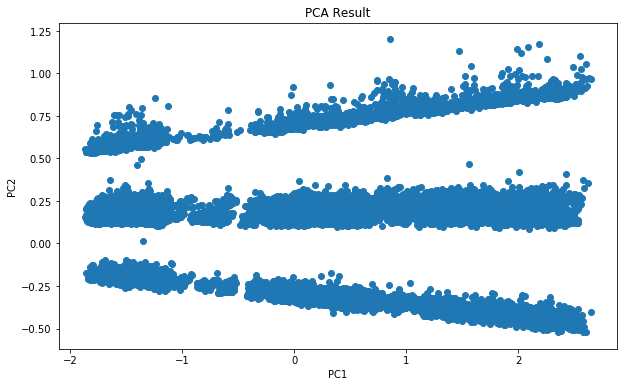

                        PC1       PC2
fret12            -0.000596 -0.002327
midpx              0.217460  0.015957
lastpx             0.217465  0.015981
open               0.217461  0.015980
high               0.217297  0.017174
low                0.219079  0.014830
bid0               0.217424  0.015897
ask0               0.217496  0.016017
bid4               0.217371  0.015829
ask4               0.217552  0.016067
bid9               0.217332  0.015810
ask9               0.217702  0.016084
bid19              0.217266  0.015764
ask19              0.217815  0.016105
bsize0            -0.006616 -0.000311
asize0            -0.000853  0.000381
bsize0_4          -0.027319 -0.008152
asize0_4          -0.002220  0.002668
bsize5_9          -0.024991 -0.013443
asize5_9          -0.002138  0.003743
bsize10_19        -0.035947 -0.021849
asize10_19        -0.005430  0.006163
btr0_4            -0.016018 -0.005866
atr0_4            -0.000675  0.002012
btr5_9            -0.014959 -0.010315
atr5_9      

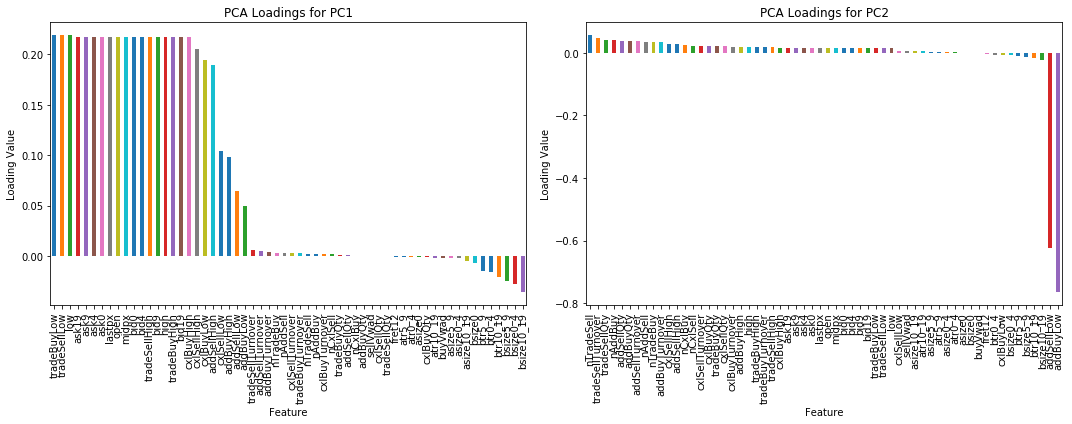

In [58]:
stock_symbol = 90000063
process_multiple_files(directory, stock_symbol)